# Prize-Collecting Steiner Trees
## Imports

In [1]:
# Import standard libraries
from importlib import reload
import csv
import OmicsIntegrator as oi
import pandas as pd
import numpy as np
import scipy.stats as ss
import networkx as nx
import matplotlib.pyplot as plt
import pickle
import tqdm
import time

# Import custom libraries
import neighborhoods as nbh
import pcst_utils as pcst

In [155]:
# Reload modules in case of modifications
reload(nbh)
reload(pcst)

<module 'pcst_utils' from '/home/braunger/masterthesis/python_code/PCST/pcst_utils.py'>

In [118]:
# File paths
data_dir = "/home/braunger/masterthesis/data/"
save_dir = "/home/braunger/masterthesis/save/pcst/"

## Preliminary Analyses about the TFs

In [201]:
# Load TF-target interactions
tf_targets = pd.read_csv(data_dir + 'tf_data/tftarget_full_processed.csv', sep = '\t')
tf_targets = tf_targets[['tf', 'target_gene']].drop_duplicates()

# filter TF-target interactions to the ones included in STRING
# since hTF also includes non-protein-coding genes
PPI = pd.read_csv(data_dir + 'ppi_data/PPI_string_processed.csv', sep = '\t')
proteins = set(PPI['protein1']).union(set(PPI['protein2']))
tf_targets = tf_targets[tf_targets['tf'].isin(proteins)]
tf_targets = tf_targets[tf_targets['target_gene'].isin(proteins)]

n_TFs = len(set(tf_targets['tf']))
print(str(n_TFs) + " out of the 48 TFs from hTFtarget are included in STRING.")

47 out of the 48 TFs from hTFtarget are included in STRING.


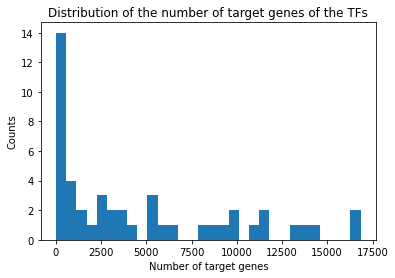

In [164]:
TF_counts = pd.DataFrame(tf_targets['tf'].value_counts())

# Histogram of number of targets
plt.figure()
plt.hist(TF_counts['tf'], bins = 30)
plt.xlabel("Number of target genes")
plt.ylabel("Counts")
plt.title("Distribution of the number of target genes of the TFs")
plt.show()

In [227]:
TF_counts

,tf
LMNB1,16835
SPI1,16789
CTCF,14042
FOXA2,13582
MAZ,13234
GTF2I,11663
CEBPB,11624
POLR2A,10976
GATA4,9981
RB1,9934


<font color='red'>Do we want to filter out those that have too many targets?</font>

# PCST Transition 0: t -> t+1 (S1)

In [165]:
# Graph hyperparameters
graph_params =  {
                "w": 2,
                "b": 2,
                "g": 0,
                "noise": 0.0, 
                "dummy_mode": "terminals", 
                "exclude_terminals": False, 
                "seed": 1,
                "pruning": 'strong',
                "verbosity_level": 0
                }

In [177]:
# Get prizes
prizes_data_0 = pcst.get_prizes("0_10", data_dir)

# Load TF data and filter df to time t + 1
tfs = pd.read_csv(data_dir+'tf_data/TF_prizes.csv')
tfs = tfs[tfs['age'] == 10]
tfs.columns = ['name', 'age', 'FPKM', 'log2_FPKM', 'prize']
tfs = tfs[['name', 'prize']]

prizes_data_0 = pd.concat([prizes_data_0, tfs])
prizes_data_0.to_csv(save_dir+'de_tf_terminals_0_10.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

In [179]:
interactome_file_name = data_dir + 'ppi_data/PPI_string_processed.csv'
prize_file_name = save_dir+'de_tf_terminals_0_10.tsv' 

augmented_forest_0 = pcst.run_pcst(graph_params, interactome_file_name, prize_file_name)

Build the graph


07:20:12 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:20:12 - OI2: INFO - ['CEBPB']
07:20:12 - OI2: INFO - Members of the prize file not present in the interactome:
07:20:12 - OI2: INFO - ['AFAP1', 'APLN', 'BBLN', 'C15orf48', 'C19orf33', 'CFAP251', 'GSTT1', 'H2AC6', 'IHO1', 'IRAG1', 'MACROH2A2', 'MGP', 'NALF1', 'NPY4R', 'SPEGNB', 'TAMALIN', 'TMSB15B', 'ZNF883']


Run PCST
Done


In [180]:
# Number of nodes and edges
n_nodes = augmented_forest_0.number_of_nodes()
n_edges = augmented_forest_0.number_of_edges()
print('The augmented forest (S1) has ' + str(n_nodes) + ' nodes and ' + str(n_edges) + ' edges.')

# Included terminals
prizes_data = pd.read_csv(save_dir+'de_tf_terminals_0_10.tsv', sep='\t')
terminals = set(prizes_data['name'].tolist())
network_df = oi.get_networkx_graph_as_dataframe_of_nodes(augmented_forest_0)
n_included_terminals = np.sum(network_df['terminal'])
percentage_terminals = n_included_terminals/len(terminals) * 100
print(str(n_included_terminals) +" of the "+str(len(terminals))+ " prized proteins (" + str(round(percentage_terminals,1)) +"%) and "+str(n_nodes-n_included_terminals)+" Steiner nodes are included.\n")

# Not-included terminals
not_incl_terminals = list(terminals.difference(network_df.index.tolist()))
prizes_not_included = prizes_data[prizes_data['name'].isin(not_incl_terminals)]
print("Prized proteins that are not included (mean prize: " + str(round(np.mean(prizes_not_included['prize']),2)) + ", min prize: " + str(round(np.min(prizes_not_included['prize']),2)) + ", max prize: "+str(round(np.max(prizes_not_included['prize']),2))+"): ")
print(*not_incl_terminals, sep = ", ")

The augmented forest (S1) has 2302 nodes and 192556 edges.
1332 of the 1350 prized proteins (98.7%) and 970 Steiner nodes are included.

Prized proteins that are not included (mean prize: 0.83, min prize: 0.5, max prize: 1.93): 
IRAG1, NPY4R, AFAP1, TAMALIN, BBLN, C15orf48, GSTT1, APLN, IHO1, SPEGNB, H2AC6, ZNF883, CFAP251, TMSB15B, C19orf33, NALF1, MGP, MACROH2A2


In [181]:
# how many of the TFs are in S1?
n_TFs_not_incl = len(set(tf_targets['tf']).difference(set(augmented_forest_0.nodes())))
print("Out of the "+str(n_TFs)+" TFs "+str(n_TFs - n_TFs_not_incl)+" TFs are included in S1 and "+str(n_TFs_not_incl)+" are not included.")

Out of the 47 TFs 40 TFs are included in S1 and 7 are not included.


# PCST Transition 1: t+1 -> t+2 (S2)

In [182]:
prizes_data_1 = pcst.get_prizes("10_20", data_dir)
prizes_data_1.to_csv(save_dir+'de_terminals_10_20.tsv', header=True, index=None, sep='\t', quoting = csv.QUOTE_NONE, escapechar = '\t')

In [183]:
interactome_file_name = data_dir + 'ppi_data/PPI_string_processed.csv'
prize_file_name = save_dir+'de_terminals_10_20.tsv'  

augmented_forest_1 = pcst.run_pcst(graph_params, interactome_file_name, prize_file_name)

Build the graph


07:27:15 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:27:15 - OI2: INFO - []
07:27:15 - OI2: INFO - Members of the prize file not present in the interactome:
07:27:15 - OI2: INFO - ['APLN', 'BBLN', 'C14orf132', 'C1QTNF3', 'C21orf91', 'C8orf89', 'CBS', 'CFAP119', 'CFAP410', 'COPS9', 'DNAAF11', 'DNAI3', 'EEF1AKMT4', 'ELAPOR2', 'H2AW', 'H2BC17', 'MT1G', 'NALF1', 'NLGN4Y', 'ODAD2', 'PCOTH', 'ZNF883']


Run PCST
Done


In [184]:
# Number of nodes and edges
n_nodes = augmented_forest_1.number_of_nodes()
n_edges = augmented_forest_1.number_of_edges()
print('The augmented forest (S2) has ' + str(n_nodes) + ' nodes and ' + str(n_edges) + ' edges.')

# Included terminals
prizes_data = pd.read_csv(save_dir+'de_terminals_10_20.tsv', sep='\t')
terminals = set(prizes_data['name'].tolist())
network_df = oi.get_networkx_graph_as_dataframe_of_nodes(augmented_forest_1)
n_included_terminals = np.sum(network_df['terminal'])
percentage_terminals = n_included_terminals/len(terminals) * 100
print(str(n_included_terminals) +" of the "+str(len(terminals))+ " prized proteins (" + str(round(percentage_terminals,1)) +"%) and "+str(n_nodes-n_included_terminals)+" Steiner nodes are included.\n")

# Not-included terminals
non_incl_terminals = list(terminals.difference(network_df.index.tolist()))
prizes_non_included = prizes_data[prizes_data['name'].isin(non_incl_terminals)]
print("Prized proteins that are not included (mean prize: " + str(round(np.mean(prizes_non_included['prize']),2)) + ", min prize: " + str(round(np.min(prizes_non_included['prize']),2)) + ", max prize: "+str(round(np.max(prizes_non_included['prize']),2))+"): ")
print(*non_incl_terminals, sep = ", ")

The augmented forest (S2) has 2289 nodes and 174737 edges.
1291 of the 1313 prized proteins (98.3%) and 998 Steiner nodes are included.

Prized proteins that are not included (mean prize: 0.6, min prize: 0.43, max prize: 1.04): 
PCOTH, ELAPOR2, C14orf132, CFAP410, COPS9, BBLN, CBS, DNAAF11, CFAP119, APLN, C21orf91, C1QTNF3, MT1G, ZNF883, H2BC17, EEF1AKMT4, C8orf89, NLGN4Y, NALF1, ODAD2, DNAI3, H2AW


In [185]:
# how many of the TFs are in S2?
n_TFs_not_incl = len(set(tf_targets['tf']).difference(set(augmented_forest_1.nodes())))
print("Out of the "+str(n_TFs)+" TFs "+str(n_TFs - n_TFs_not_incl)+" TFs are included in S2 and "+str(n_TFs_not_incl)+" are not included.")

Out of the 47 TFs 11 TFs are included in S2 and 36 are not included.


# Combined PCST (S3)

In [186]:
augmented_forest = pcst.run_pcst_combi("0_10_20", augmented_forest_0, augmented_forest_1, graph_params, data_dir, save_dir)

Build the graph


07:31:05 - OI2: INFO - Duplicated gene symbols in the prize file (we'll keep the max prize):
07:31:05 - OI2: INFO - ['CEBPB_tr0']
07:31:05 - OI2: INFO - Members of the prize file not present in the interactome:
07:31:05 - OI2: INFO - ['AFAP1_tr0', 'APLN_tr0', 'APLN_tr1', 'BBLN_tr0', 'BBLN_tr1', 'C14orf132_tr1', 'C15orf48_tr0', 'C19orf33_tr0', 'C1QTNF3_tr1', 'C21orf91_tr1', 'C8orf89_tr1', 'CBS_tr1', 'CFAP119_tr1', 'CFAP251_tr0', 'CFAP410_tr1', 'COPS9_tr1', 'DNAAF11_tr1', 'DNAI3_tr1', 'EEF1AKMT4_tr1', 'ELAPOR2_tr1', 'GSTT1_tr0', 'H2AC6_tr0', 'H2AW_tr1', 'H2BC17_tr1', 'IHO1_tr0', 'IRAG1_tr0', 'MACROH2A2_tr0', 'MGP_tr0', 'MT1G_tr1', 'NALF1_tr0', 'NALF1_tr1', 'NLGN4Y_tr1', 'NPY4R_tr0', 'ODAD2_tr1', 'PCOTH_tr1', 'SPEGNB_tr0', 'TAMALIN_tr0', 'TMSB15B_tr0', 'ZNF883_tr0', 'ZNF883_tr1']


Run PCST
Done


In [187]:
# Save selected network to file
oi.output_networkx_graph_as_interactive_html(augmented_forest, filename=save_dir + "network_0_10_20.html")
oi.output_networkx_graph_as_pickle(augmented_forest, filename= save_dir + "network_0_10_20.pickle")

PosixPath('/home/braunger/masterthesis/save/pcst/network_0_10_20.pickle')

# Analyses of the results

In [194]:
# Number of nodes and edges
n_nodes = augmented_forest.number_of_nodes()
n_edges = augmented_forest.number_of_edges()
print('The augmented forest (S3) has ' + str(n_nodes) + ' nodes and ' + str(n_edges) + ' edges.')

# Included terminals
prizes_data = pd.read_csv(save_dir+'de_tf_terminals_0_10_20.tsv', sep='\t')
terminals = set(prizes_data['name'].tolist())
network_df = oi.get_networkx_graph_as_dataframe_of_nodes(augmented_forest)
n_included_terminals = np.sum(network_df['terminal'])
percentage_terminals = n_included_terminals/len(terminals) * 100
print(str(n_included_terminals) +" of the "+str(len(terminals))+ " prized proteins (" + str(round(percentage_terminals,1)) +"%) and "+str(n_nodes-n_included_terminals)+" Steiner nodes are included.\n")

# Not-included terminals
non_incl_terminals = list(terminals.difference(network_df.index.tolist()))
prizes_non_included = prizes_data[prizes_data['name'].isin(non_incl_terminals)]
print("Prized proteins that are not included (mean prize: " + str(round(np.mean(prizes_non_included['prize']),2)) + ", min prize: " + str(round(np.min(prizes_non_included['prize']),2)) + ", max prize: "+str(round(np.max(prizes_non_included['prize']),2))+"): ")
print(*non_incl_terminals, sep = ", ")

The augmented forest (S3) has 4516 nodes and 371249 edges.
2623 of the 2663 prized proteins (98.5%) and 1893 Steiner nodes are included.

Prized proteins that are not included (mean prize: 0.71, min prize: 0.43, max prize: 1.93): 
CBS_tr1, APLN_tr0, C21orf91_tr1, NALF1_tr1, C8orf89_tr1, ODAD2_tr1, NPY4R_tr0, IRAG1_tr0, EEF1AKMT4_tr1, CFAP251_tr0, C19orf33_tr0, MGP_tr0, ELAPOR2_tr1, H2BC17_tr1, COPS9_tr1, GSTT1_tr0, ZNF883_tr0, SPEGNB_tr0, TAMALIN_tr0, DNAI3_tr1, C15orf48_tr0, CFAP410_tr1, PCOTH_tr1, IHO1_tr0, H2AW_tr1, BBLN_tr1, C14orf132_tr1, BBLN_tr0, APLN_tr1, TMSB15B_tr0, MT1G_tr1, MACROH2A2_tr0, AFAP1_tr0, DNAAF11_tr1, H2AC6_tr0, CFAP119_tr1, NALF1_tr0, ZNF883_tr1, NLGN4Y_tr1, C1QTNF3_tr1


In [205]:
# TFs
#tf_targets['tf'] = tf_targets['tf'] + "_tr0"    
TFs = list(set(tf_targets['tf']))
TF_df = network_df[network_df.index.isin([TF + "_tr0" for TF in TFs])]
TF_df.head()

,prize,terminal,type,degree,betweenness,louvain_clusters
CREBBP_tr0,0.386096,True,protein,1448,0.011503,1
TP53_tr0,0.426367,True,protein,2884,0.062172,1
EP300_tr0,0.415597,True,protein,2225,0.039299,0
CEBPB_tr0,0.482755,True,protein,2507,0.066906,0
PRKDC_tr0,0.599020,True,protein,830,0.003167,1


In [221]:
# Self-redundancy
TFs_incl = [TF[:-4] for TF in TF_df.index.tolist()]
tf_self_targets = tf_targets[tf_targets['target_gene'].isin(TFs_incl)]
print(str(len(TFs_incl))+ " TFs are included in S3 and there are "+ str(tf_self_targets.shape[0]) + " edges between the selected TFs." )

39 TFs are included in S3 and there are 662 edges between the selected TFs.


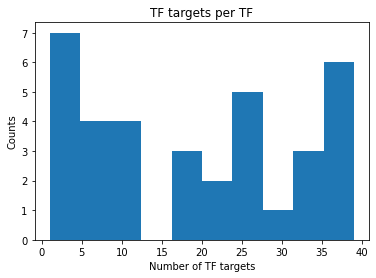

In [225]:
plt.figure()
plt.hist(pd.DataFrame(tf_self_targets['tf'].value_counts())['tf'])
plt.title('TF targets per TF')
plt.xlabel("Number of TF targets")
plt.ylabel("Counts")
plt.show()

In [226]:
tf_self_targets['tf'].value_counts()

SPI1      39
LMNB1     39
MAZ       39
FOXA2     38
CTCF      37
POLR2A    36
CEBPB     34
RB1       33
GTF2I     32
CHD1      28
TP53      27
RAD21     25
GATA4     25
KLF4      24
MYC       24
EP300     22
RBL2      20
E2F7      19
GTF2B     18
MAFK      17
SUMO2     12
MXI1      11
MITF      10
PHF8      10
SOX2       8
RFX5       8
POU5F1     6
SUMO1      5
CREBBP     4
BRD7       3
RCOR1      2
STAG1      2
KDM1A      2
PCGF2      2
CHD7       1
Name: tf, dtype: int64

47